In [2]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Module relatif à Gurobi
import gurobipy as gp
from gurobipy import GRB   

# Classement

On récupère les classements réalisé par l'agent.

In [24]:
path = "../data/Preferences.csv"
past_prefs = np.genfromtxt(path, delimiter=";", skip_header=1, dtype=str)
past_prefs = np.char.replace(past_prefs, ',', '.').astype(float)
past_prefs = past_prefs[:,1:]
print("number of examples:",len(past_prefs))
print("exemple:")
print(past_prefs[0:5,:])

number of examples: 39
exemple:
[[83.72  1.07  1.  ]
 [86.06  1.12  0.  ]
 [89.66  1.11  1.  ]
 [80.19  1.23  1.  ]
 [79.23  1.18  2.  ]]


# Modélisation

## Modélisation du score

On modélise le score sur les 3 dimenssions de la facçon suivante (sous la forme UTA):

Le score est la somme des dimensions pondéré par un poids, pour chaque dimension le poid est une fonction linéaire par morceau, monotone, croissante et continue. qui vaut 0 pour la valeur minimale et 1 pour la valeur maximale. x etant un vecteur de taille 3, le score est donc donné par:

$$
score(x) = \sum_{i=1}^{3} \omega_i(x_i) \times x_i
$$

avec 

$$
\omega_i(x_i) = \omega_i^k + (x_i - x_i^k) \times \frac{\omega_i^{k+1} - 
\omega_i^k}{x_i^{k+1} - x_i^k} \text{   avec   } x_i^k \leq x_i \leq x_i^{k+1}
$$

où :

$$
x_i^k = min_i + k \frac{max_i - min_i}{L_i} 
$$

et $\omega_i^k$ est la valeur de $\omega_i$ en $x_i^k$

Les paramêtres à déterminer sont donc les $(w_i^k)_{i=1,2,3;\ k \in |[0,L_i]|}$


Les valeurs minimales et maximales étant définis arbitraiement suivant les classements , on extrapole les fonction $\omega_i$ pour les valeurs inférieures et supérieures à $x_i^0$ et $x_i^{L_i}$ par les valeurs constante $\omega_i^0$ et $\omega_i^{L_i}$.

## Optimisation du score

à partir du classement effectué par l'agent, on approxime le score pour chaque SR classé de la façon suivante (on dispose de n SR classé avec leur scores):

$$
H(x^t) =  score(x^t) + \epsilon^t
$$

avec $\epsilon^t$ une variable du problème d'optimisation.

On fixe un seuil $\delta = 1e^{-3}$ et on ajoute les contraintes suivante:

$$
\forall t \in [1,n-1],\ H(x^t) \leq H(x^{t+1})) - \delta
$$

et on minimise la somme des $\epsilon^t$. la fonction objectif est donc:

$$
\min( \sum_{t=1}^{n} \epsilon^t )
$$

In [25]:
# calcul functions

def score_i(x,W,S,i):
    """
    Args:
        x (float): value to calculate the score of
        W (np.ndarray): X absice steps
        S (np.ndarray): steps values on Y axis
    """
    # find k such that W[i,k] <= x < W[i,k+1]
    k = 0
    if x < W[0,i]:
        return S[0,i]
    while x >= W[k+1,i]:
        if k < len(W)-2:
            k += 1
        else:
            return S[k+1,i]
        
    # linear interpolation
    return S[k,i] + (S[k+1,i]-S[k,i])/(W[k+1,i]-W[k,i])*(x-W[k,i])

def sum_scores(X,W,S):
    # X_scores = np.zeros(len(X))
    sm = 0
    for i in range(len(X)):
        sm+=score_i(X[i],W,S,i)
    return sm

In [26]:
# optimization function

number_criterion = past_prefs.shape[1]
number_divisions = 5 # nombre parties linéaires par morceaux.

epsilon = 1e-2

model = gp.Model("Ranking")

mins = np.min(past_prefs, axis=0)
maxs = np.max(past_prefs, axis=0)
# mins = np.min(past, axis=0)
# maxs = np.max(past, axis=0)
print(mins,maxs)
W = np.linspace(mins,maxs,number_divisions) # les steps sur l'axe des x

# Variables de décision
S  = model.addMVar((number_divisions,number_criterion), vtype=GRB.CONTINUOUS, name="S")

print(W.shape,S.shape)

# boundaries
sum_constr = model.addConstr(S[-1,:].sum() == 1)
min_const = model.addConstr(np.min(S)>=0 )
max_const = model.addConstr(np.max(S)<=1 )
constr_0 = model.addConstr(S[0,:]==0)

# monotonie
for i in range(number_criterion):
    for j in range(number_divisions-1):
        model.addConstr(S[j,i] <= S[j+1,i])

# Contraintes de classement
n_past = len(past_prefs)
eps = model.addVars(n_past,vtype=GRB.CONTINUOUS,name="eps")
for i in range(n_past):
    model.addConstr(eps[i] >= 0)
for i in range(n_past-1):
    model.addConstr(sum_scores(past_prefs[i,:],W,S) + eps[i] <= sum_scores(past_prefs[i+1,:],W,S) + eps[i+1] - epsilon)


model.setObjective(eps.sum(),GRB.MINIMIZE)

model.setParam('OutputFlag', 0)
model.update()

model.optimize()

print("Optimal value:", model.objVal)

print("Optimal solution:")
print(S.X)





[75.21  1.03  0.  ] [185.9    1.49   4.  ]
(5, 3) (5, 3)
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimal value: 0.0691596368581355
Optimal solution:
[[0.         0.         0.        ]
 [0.217524   0.08984907 0.0171532 ]
 [0.39212574 0.21370584 0.11297719]
 [0.39724128 0.28212163 0.20378082]
 [0.40129314 0.28212163 0.31658523]]


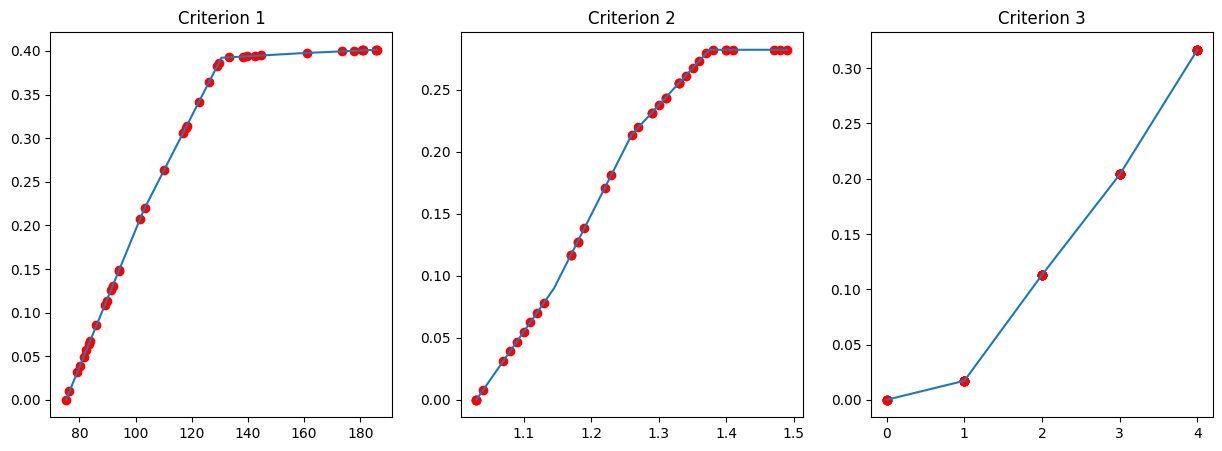

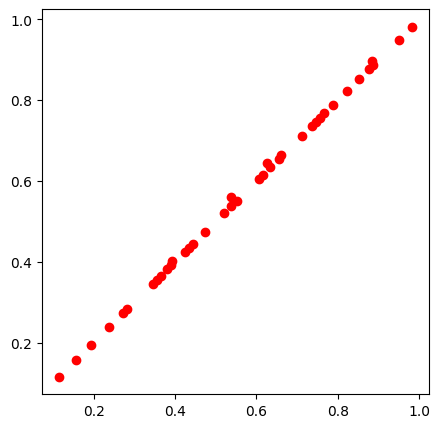

In [27]:
import matplotlib.pyplot as plt




fig,axs = plt.subplots(1,S.shape[1],figsize=(15,5))
for i in range(S.shape[1]):
    axs[i].plot(W[:,i],S.X[:,i])
    axs[i].set_title("Criterion "+str(i+1))
for i in range(past_prefs.shape[0]):
    axs[0].scatter(past_prefs[i,0],score_i(past_prefs[i,0],W,S.X,0),color="red")
    axs[1].scatter(past_prefs[i,1],score_i(past_prefs[i,1],W,S.X,1),color="red")
    axs[2].scatter(past_prefs[i,2],score_i(past_prefs[i,2],W,S.X,2),color="red")
    # print(sum_scores(past_prefs[i,:],W,S.X))
    

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
X = [ sum_scores(past_prefs[i,:],W,S.X) for i in range(past_prefs.shape[0])]
Y = [ X[i] + eps[i].X for i in range(past_prefs.shape[0])]
ax.scatter(X, Y ,color="red")
    
# print("New projects")
# for i in range(P.shape[0]):
#     axs[0].scatter(P[i,0],score_i(P[i,0],W,S.X,0),color="blue")
#     axs[1].scatter(P[i,1],score_i(P[i,1],W,S.X,1),color="blue")
#     axs[2].scatter(P[i,2],score_i(P[i,2],W,S.X,2),color="blue")
#     print(sum_scores(P[i,:],W,S.X))

# Finale loss 
à utiliser pour opitmiser les changements à faire

In [28]:
print("S : \n",S.X)
print("W : \n",W)

S : 
 [[0.         0.         0.        ]
 [0.217524   0.08984907 0.0171532 ]
 [0.39212574 0.21370584 0.11297719]
 [0.39724128 0.28212163 0.20378082]
 [0.40129314 0.28212163 0.31658523]]
W : 
 [[ 75.21     1.03     0.    ]
 [102.8825   1.145    1.    ]
 [130.555    1.26     2.    ]
 [158.2275   1.375    3.    ]
 [185.9      1.49     4.    ]]


In [29]:
Sfin = S.X
Wfin = W

loss = lambda x: sum_scores(x,Wfin,Sfin)

In [64]:

# ranking 
non_dominated_path = "../step_3/non_dominant_solutions_tri_objectives.csv"
choices = np.genfromtxt(non_dominated_path, delimiter=",", skip_header=1, dtype=float)
choices = choices[:,:]
# print(choices)

ranking = np.argsort([loss(choices[i,:]) for i in range(choices.shape[0])])
print("ranks:\n",ranking)


print("ranking:")
for i in range(5):
    # print(choices[ranking[i],:])
    print(i+1,"& ",end="")
    print(round(loss(choices[ranking[i],:]),3),end="")
    for j in range(3):
        print(" & ",end="")
        print(round(choices[ranking[i],j],2),end="")
    print("")
    print("\hline")
    # print("-------------")


ranks:
 [ 9  8  6  7 14 13 11  4 12 10  3  2  1 19 18 17 16 15  5 24 23 22 21  0
 20]
ranking:
1 & 0.314 & 114.94 & 1.03 & 1.0
\hline
2 & 0.322 & 112.92 & 1.06 & 1.0
\hline
3 & 0.331 & 108.81 & 1.1 & 1.0
\hline
4 & 0.333 & 112.62 & 1.08 & 1.0
\hline
5 & 0.387 & 111.79 & 1.01 & 2.0
\hline
